In [1]:
%matplotlib inline

# Imports
import gc
import matplotlib.pyplot as plt
import os
import statsmodels.stats.proportion

# seaborn
import seaborn
seaborn.set()
seaborn.set_style("darkgrid")

# Project imports
from legacy_model import *

In [2]:
# Get raw data
raw_data = get_raw_scdb_data("../data/input/SCDB_Legacy_01_justiceCentered_Citation.csv")

# Get feature data
if os.path.exists("../data/output/feature_data.hdf.gz"):
    print("Loading from HDF5 cache")
    feature_df = pandas.read_hdf("../data/output/feature_data.hdf.gz", "root")
else:
    # Process
    feature_df = preprocess_raw_data(raw_data, include_direction=True)
    
    # Write out feature datas
    feature_df.to_hdf("../data/output/feature_data.hdf.gz", "root", complevel=6, complib="zlib")

Loading from HDF5 cache


In [3]:
# Downsample to float
feature_df = feature_df.astype(numpy.float16)

In [4]:
# Remove term
nonterm_features = [f for f in feature_df.columns if not f.startswith("term_")]
original_feature_df = feature_df.copy()
feature_df = original_feature_df.loc[:, nonterm_features].copy()
gc.collect()

2130

In [5]:
# Output some diagnostics on features
print(raw_data.shape)
print(feature_df.shape)
assert(raw_data.shape[0] == feature_df.shape[0])

(249793, 64)
(249793, 1501)


In [6]:
# Output basic quantities for sample
print(pandas.DataFrame(raw_data["justice_outcome_disposition"].value_counts()))
print(pandas.DataFrame(raw_data["justice_outcome_disposition"].value_counts(normalize=True)))

    justice_outcome_disposition
 0                       114780
 1                        94505
-1                        40508
    justice_outcome_disposition
 0                     0.459500
 1                     0.378333
-1                     0.162166


In [7]:
# Reset output file timestamp per run
file_timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

# Reset seed per run
numpy.random.seed(0)

# Setup training time period
dummy_window = 9999
min_training_years = 50
term_range = range(raw_data["term"].min() + min_training_years,
                   raw_data["term"].max()+1)

# Setting growing random forest parameters
# Number of trees to grow per term
trees_per_term = 5

# Number of trees to begin with
initial_trees = min_training_years * trees_per_term

# Number of years between "forest fires"
reset_interval = 9999

# Setup model
m = None
term_count = 0
feature_importance_df = pandas.DataFrame()

for term in term_range:
    # Diagnostic output
    print("Term: {0}".format(term))
    term_count += 1
    
    # Setup train and test periods
    train_index = (raw_data.loc[:, "term"] < term).values
    dummy_train_index = ((raw_data.loc[:, "term"] < term) & (raw_data.loc[:, "term"] >= (term-dummy_window))).values
    test_index = (raw_data.loc[:, "term"] == term).values
    
    # Setup train data
    feature_data_train = feature_df.loc[train_index, :]
    target_data_train = (raw_data.loc[train_index, "justice_outcome_disposition"]).astype(int)

    # Setup test data
    feature_data_test = feature_df.loc[test_index, :]
    target_data_test = (raw_data.loc[test_index, "justice_outcome_disposition"]).astype(int)
        
    # Check if we should rebuild the model based on changing natural court
    if term_count % reset_interval == 0:
        # "Forest fire;" grow a new forest from scratch
        print("Reset interval hit; rebuilding with {0} trees".format(initial_trees + (term_count * trees_per_term)))
        m = None
    else:
        # Check if the justice set has changed
        if set(raw_data.loc[raw_data.loc[:, "term"] == (term-1), "naturalCourt"].unique()) != \
            set(raw_data.loc[raw_data.loc[:, "term"] == (term), "naturalCourt"].unique()):
            # natural Court change; trigger forest fire
            print("Natural court change; rebuilding with {0} trees".format(initial_trees + (term_count * trees_per_term)))
            m = None
                                              
    # Build or grow a model depending on initial/reset condition
    if not m:
        # Grow an initial forest
        m = sklearn.ensemble.RandomForestClassifier(n_estimators=initial_trees + (term_count * trees_per_term), 
                                                    #class_weight="balanced_subsample",
                                                    warm_start=True,
                                                    n_jobs=-1)
    else:
        # Grow the forest by increasing the number of trees (requires warm_start=True)
        m.set_params(n_estimators=initial_trees + (term_count * trees_per_term))

    # Fit the forest model
    m.fit(feature_data_train,
          target_data_train)
    
    # Record feature weights
    current_feature_importance_df = pandas.DataFrame(list(zip(feature_df.columns, m.feature_importances_)),
                                         columns=["feature", "importance"])
    current_feature_importance_df.loc[:, "term"] = term
    if feature_importance_df.shape[0] == 0:
        feature_importance_df = current_feature_importance_df.copy()
    else:
        feature_importance_df = feature_importance_df.append(current_feature_importance_df.copy())

    # Fit the "dummy" model
    d = sklearn.dummy.DummyClassifier(strategy="most_frequent")
    d.fit(feature_df.loc[dummy_train_index, :],
          (raw_data.loc[dummy_train_index, "justice_outcome_disposition"]).astype(int))
    
    # Perform forest predictions
    raw_data.loc[test_index, "rf_predicted"] = m.predict(feature_data_test)
    
    # Store scores per class
    scores = m.predict_proba(feature_data_test)
    raw_data.loc[test_index, "rf_predicted_score_other"] = scores[:, 0]
    raw_data.loc[test_index, "rf_predicted_score_affirm"] = scores[:, 1]
    raw_data.loc[test_index, "rf_predicted_score_reverse"] = scores[:, 2]
    
    # Store dummy predictions
    raw_data.loc[test_index, "dummy_predicted"] = d.predict(feature_data_test)
    
    #  Clear
    del feature_data_train
    del feature_data_test
    del target_data_train
    del target_data_test
    gc.collect()

Term: 1841
Term: 1842
Natural court change; rebuilding with 260 trees
Term: 1843
Term: 1844
Term: 1845
Natural court change; rebuilding with 275 trees
Term: 1846
Natural court change; rebuilding with 280 trees
Term: 1847
Natural court change; rebuilding with 285 trees
Term: 1848
Term: 1849
Term: 1850
Natural court change; rebuilding with 300 trees
Term: 1851
Natural court change; rebuilding with 305 trees
Term: 1852
Term: 1853
Natural court change; rebuilding with 315 trees
Term: 1854
Term: 1855
Term: 1856
Term: 1857
Natural court change; rebuilding with 335 trees
Term: 1858
Natural court change; rebuilding with 340 trees
Term: 1859
Term: 1860
Term: 1861
Natural court change; rebuilding with 355 trees
Term: 1862
Natural court change; rebuilding with 360 trees
Term: 1863
Natural court change; rebuilding with 365 trees
Term: 1864
Natural court change; rebuilding with 370 trees
Term: 1865
Term: 1866
Term: 1867
Term: 1868
Term: 1869
Natural court change; rebuilding with 395 trees
Term: 187

In [8]:
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range)
target_actual = (raw_data.loc[evaluation_index, "justice_outcome_disposition"]).astype(int)
target_predicted = raw_data.loc[evaluation_index, "rf_predicted"].astype(int)
target_dummy = raw_data.loc[evaluation_index, "dummy_predicted"].astype(int)
raw_data.loc[:, "rf_correct"] = numpy.nan
raw_data.loc[:, "dummy_correct"] = numpy.nan
raw_data.loc[evaluation_index, "rf_correct"] = (target_actual == target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_correct"] = (target_actual == target_dummy).astype(float)

# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_predicted))
print(sklearn.metrics.confusion_matrix(target_actual, target_predicted))
print(sklearn.metrics.accuracy_score(target_actual, target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_dummy))
print(sklearn.metrics.confusion_matrix(target_actual, target_dummy))
print(sklearn.metrics.accuracy_score(target_actual, target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

         -1       0.81      0.61      0.70     37465
          0       0.62      0.75      0.68    110640
          1       0.63      0.53      0.58     91381

avg / total       0.65      0.65      0.64    239486

[[22938 10094  4433]
 [ 3499 83425 23716]
 [ 1963 41007 48411]]
0.646275773949

Dummy model
             precision    recall  f1-score   support

         -1       0.00      0.00      0.00     37465
          0       0.46      1.00      0.63    110640
          1       0.00      0.00      0.00     91381

avg / total       0.21      0.46      0.29    239486

[[     0  37465      0]
 [     0 110640      0]
 [     0  91381      0]]
0.461989427357



/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


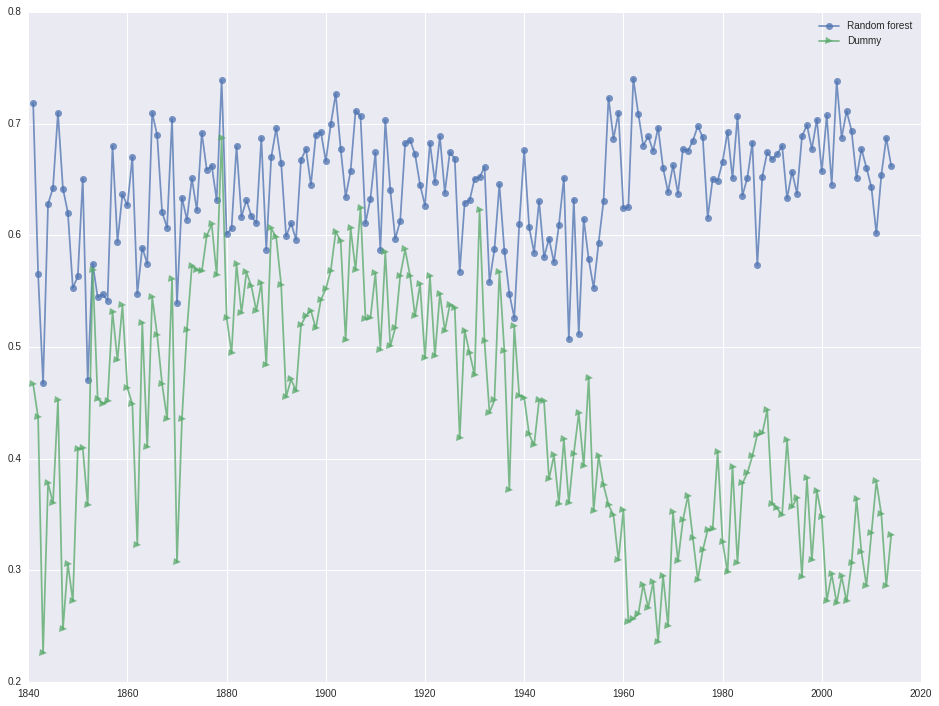

In [9]:
# Setup time series
rf_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["rf_correct"].mean()
dummy_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["dummy_correct"].mean()

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_correct_ts.index, rf_correct_ts,
         marker='o', alpha=0.75)
plt.plot(dummy_correct_ts.index, dummy_correct_ts,
         marker='>', alpha=0.75)
plt.legend(('Random forest', 'Dummy'))

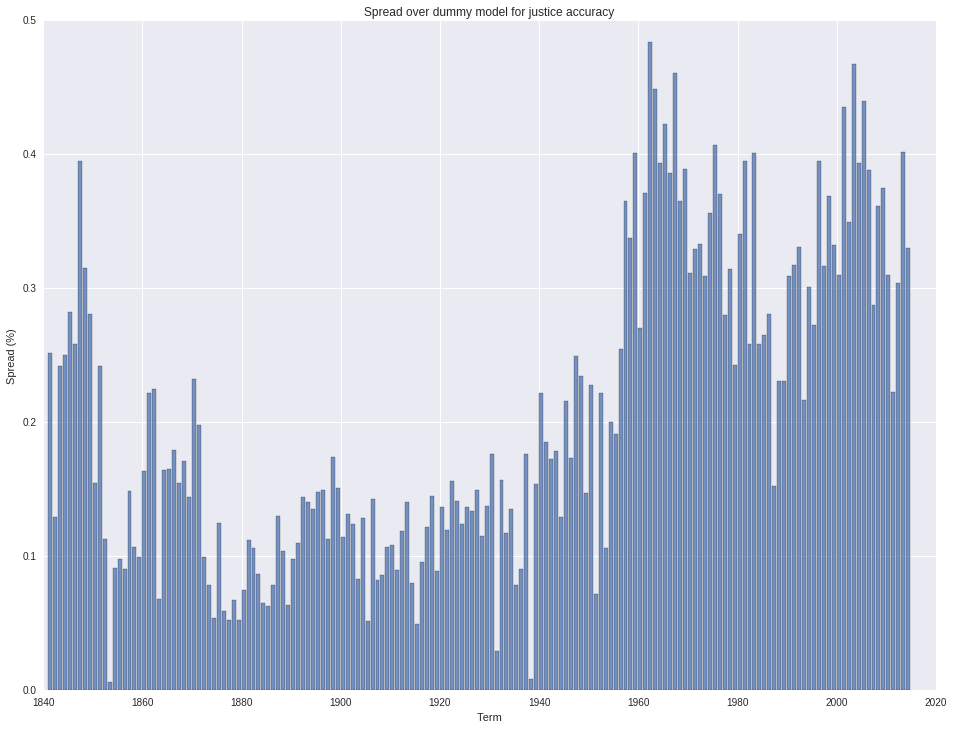

In [10]:
# Setup time series
rf_spread_ts = rf_correct_ts - dummy_correct_ts

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.bar(rf_spread_ts.index, rf_spread_ts,
        alpha=0.75)
plt.xlabel("Term")
plt.ylabel("Spread (%)")
plt.title("Spread over dummy model for justice accuracy")

In [11]:
# Feature importance
last_feature_importance_df = pandas.DataFrame(list(zip(feature_df.columns, m.feature_importances_)),
                                         columns=["feature", "importance"])
last_feature_importance_df.sort_values(["importance"], ascending=False).head(10)

,feature,importance
1499,justice_previous_lc_direction_diff,0.031461
1500,justice_cumulative_lc_direction_diff,0.030051
131,decision_delay,0.025201
1487,justice_previous_action,0.018488
1495,justice_previous_court_agreement,0.017797
1489,justice_previous_court_action,0.017576
1488,justice_cumulative_action,0.017047
0,natural_court_raw,0.016940
1496,justice_cumulative_court_agreement,0.016916
1490,justice_cumulative_court_action,0.016702


In [12]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_ts.values,
                   dummy_correct_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_ts.values,
                   dummy_correct_ts.values))

print("=" * 16)
print("Binomial:")
print(statsmodels.stats.proportion.binom_test(raw_data.loc[evaluation_index, "rf_correct"].sum(),
                                              raw_data.loc[evaluation_index, "rf_correct"].shape[0],
                                              raw_data.loc[evaluation_index, "dummy_correct"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=23.509848450558064, pvalue=9.4509142397830143e-56)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=15.062385142521807, pvalue=2.8626980495415994e-51)
Binomial:
0.0


In [13]:
# Get case-level prediction
#scdb_data.loc[evaluation_index, "rf_predicted_case"] = 
rf_predicted_case = pandas.DataFrame(raw_data.loc[evaluation_index, :]\
    .groupby(["docketId"])["rf_predicted"]\
    .agg(lambda x: x.value_counts().index[0]))
rf_predicted_case.columns = ["rf_predicted_case"]

dummy_predicted_case = pandas.DataFrame(raw_data.loc[evaluation_index, :]\
    .groupby(["docketId"])["dummy_predicted"]\
    .agg(lambda x: x.value_counts().index[0]))
dummy_predicted_case.columns = ["dummy_predicted_case"]

# Set DFs
rf_predicted_case = raw_data[["docketId", "case_outcome_disposition", "rf_predicted"]].join(rf_predicted_case, on="docketId")
dumy_predicted_case = raw_data[["docketId", "dummy_predicted"]].join(dummy_predicted_case, on="docketId")

raw_data.loc[:, "rf_predicted_case"] = rf_predicted_case
raw_data.loc[:, "dummy_predicted_case"] = dumy_predicted_case

In [14]:
# Output case distribution
case_outcomes = raw_data.groupby(["docketId"])["case_outcome_disposition"].apply(lambda x: x.mode())
case_outcomes = case_outcomes.apply(lambda x: int(x) if type(x) in [numpy.float64] else None)
case_outcomes  = (case_outcomes).astype(int)
print(case_outcomes.value_counts())
print(case_outcomes.value_counts(normalize=True))

 0    13270
 1    11503
-1     3490
dtype: int64
 0    0.469518
 1    0.406999
-1    0.123483
dtype: float64


In [15]:
# Output comparison
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range) & -raw_data.loc[:, "case_outcome_disposition"].isnull()
target_actual = (raw_data.loc[evaluation_index, "case_outcome_disposition"] > 0).astype(int)
target_predicted = (raw_data.loc[evaluation_index, "rf_predicted_case"] > 0).astype(int)
target_dummy = (raw_data.loc[evaluation_index, "dummy_predicted_case"] > 0).astype(int)

raw_data.loc[:, "rf_correct_case"] = numpy.nan
raw_data.loc[:, "dummy_correct_case"] = numpy.nan
raw_data.loc[evaluation_index, "rf_correct_case"] = (target_actual == target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_correct_case"] = (target_actual == target_dummy).astype(float)

# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_predicted))
print(sklearn.metrics.confusion_matrix(target_actual, target_predicted))
print(sklearn.metrics.accuracy_score(target_actual, target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_dummy))
print(sklearn.metrics.confusion_matrix(target_actual, target_dummy))
print(sklearn.metrics.accuracy_score(target_actual, target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

          0       0.72      0.81      0.76    139384
          1       0.67      0.56      0.61     97862

avg / total       0.70      0.70      0.70    237246

[[112234  27150]
 [ 43269  54593]]
0.703181507802

Dummy model
             precision    recall  f1-score   support

          0       0.59      1.00      0.74    139384
          1       0.00      0.00      0.00     97862

avg / total       0.35      0.59      0.43    237246

[[139384      0]
 [ 97862      0]]
0.587508324693



/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


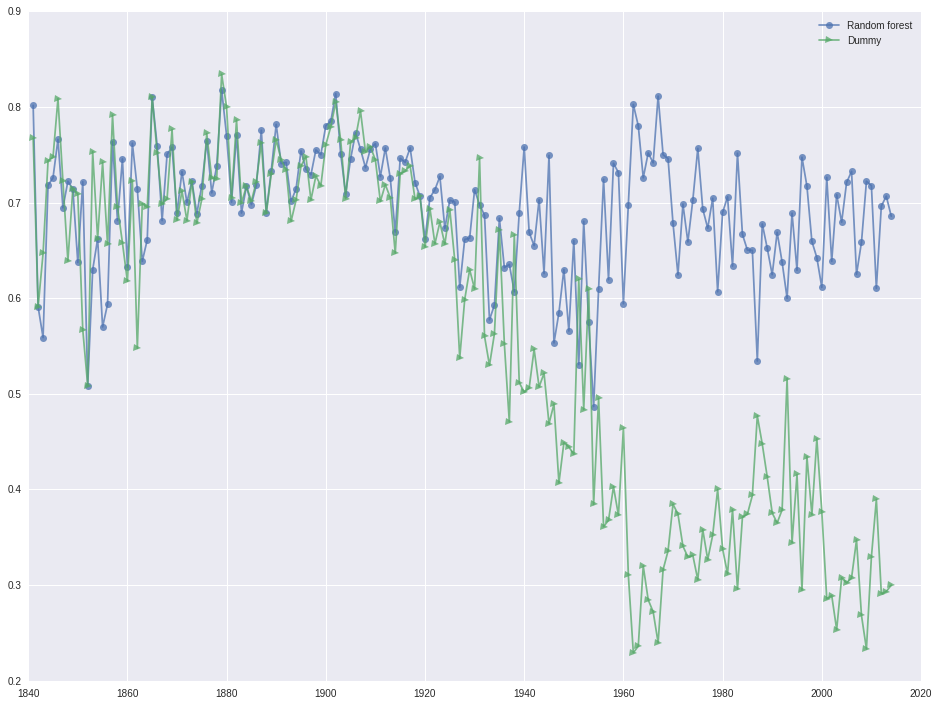

In [16]:
# Setup time series
rf_correct_case_ts = raw_data.loc[evaluation_index, :].groupby("term")["rf_correct_case"].mean()
dummy_correct_case_ts = raw_data.loc[evaluation_index, :].groupby("term")["dummy_correct_case"].mean()

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_correct_case_ts.index, rf_correct_case_ts,
         marker='o', alpha=0.75)
plt.plot(dummy_correct_case_ts.index, dummy_correct_case_ts,
         marker='>', alpha=0.75)
plt.legend(('Random forest', 'Dummy'))

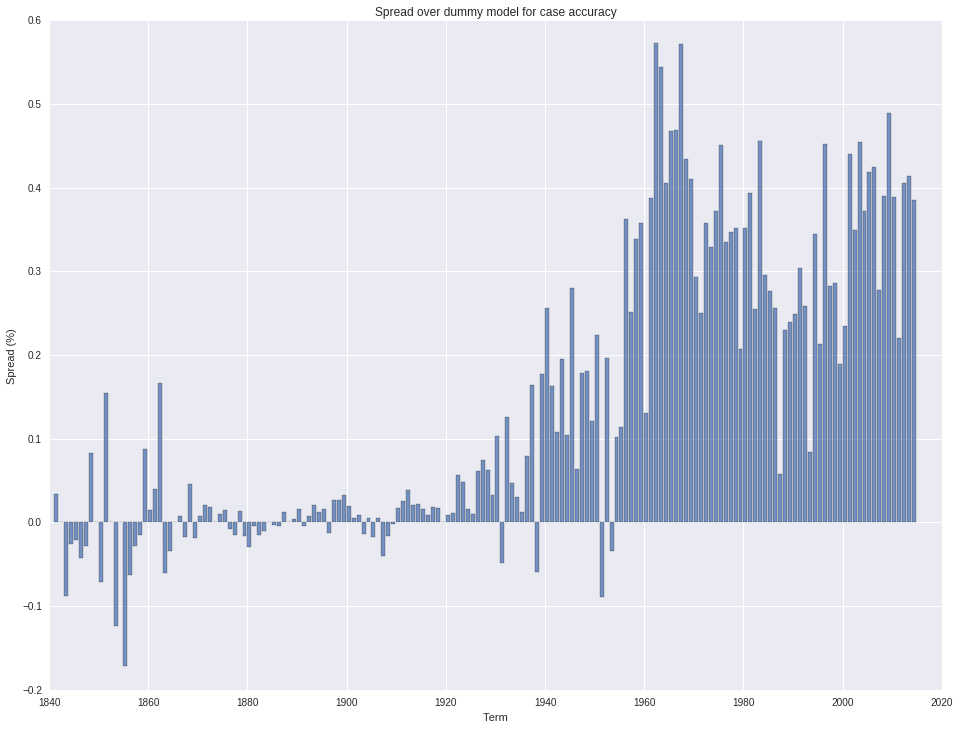

In [17]:
# Setup time series
rf_spread_case_ts = rf_correct_case_ts - dummy_correct_case_ts

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.bar(rf_spread_case_ts.index, rf_spread_case_ts,
        alpha=0.75)
plt.xlabel("Term")
plt.ylabel("Spread (%)")
plt.title("Spread over dummy model for case accuracy")

/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.expanding_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).sum()
  from ipykernel import kernelapp as app


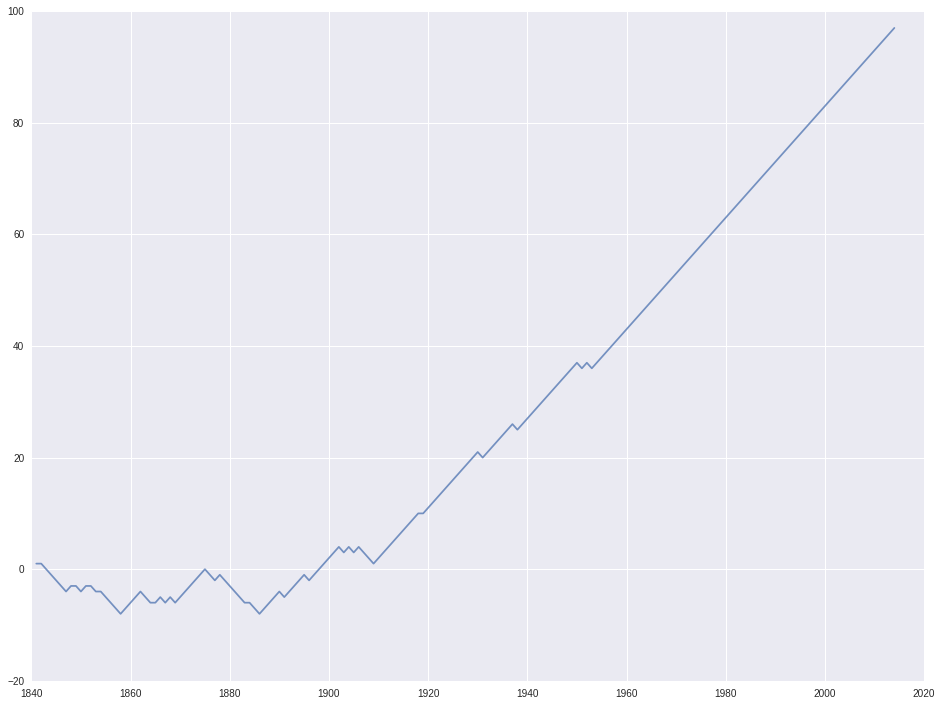

In [18]:
# Setup time series
rf_spread_case_dir_ts = pandas.expanding_sum(numpy.sign(rf_spread_case_ts))

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_spread_case_dir_ts.index, rf_spread_case_dir_ts,
        alpha=0.75)

In [19]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("Binomial:")
case_accuracy_data = raw_data.loc[evaluation_index, ["docketId", "rf_correct_case", "dummy_correct_case"]].drop_duplicates()
print(statsmodels.stats.proportion.binom_test(case_accuracy_data["rf_correct_case"].sum(),
                                              case_accuracy_data["rf_correct_case"].shape[0],
                                              case_accuracy_data["dummy_correct_case"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=10.325561322906619, pvalue=8.9315929171141297e-20)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=6.3061882043917352, pvalue=2.8599124645750147e-10)
Binomial:
0.0


In [20]:
raw_data.loc[raw_data.loc[:, "caseName"] == "MIRANDA v. ARIZONA", 
              ["caseName", "justiceName", "case_outcome_disposition", "justice_outcome_disposition",
              "rf_predicted", "rf_predicted_score_affirm", "rf_predicted_score_reverse", "rf_correct_case", "dummy_correct_case"]].T

,194698,194699,194700,194701,194702,194703,194704,194705,194706
caseName,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA
justiceName,JHarlan2,HLBlack,WODouglas,PStewart,WJBrennan,BRWhite,EWarren,TCClark,AFortas
case_outcome_disposition,1,1,1,1,1,1,1,1,1
justice_outcome_disposition,0,1,1,0,1,0,1,0,1
rf_predicted,0,1,1,0,1,1,1,1,1
rf_predicted_score_affirm,0.563429,0.203048,0.156571,0.574971,0.297143,0.461143,0.202857,0.475429,0.337714
rf_predicted_score_reverse,0.387429,0.761524,0.820571,0.399886,0.667429,0.497714,0.716,0.496,0.518286
rf_correct_case,1,1,1,1,1,1,1,1,1
dummy_correct_case,0,0,0,0,0,0,0,0,0


In [21]:
# Output file data
raw_data.to_csv("../data/output/scdb_legacy_raw_data_most_frequent_{0}.csv".format(file_timestamp))
case_accuracy_data.to_csv("../data/output/scdb_legacy_case_data_most_frequent_{0}.csv".format(file_timestamp))
feature_importance_df.to_csv("../data/output/scdb_legacy_last_features_most_frequent_{0}.csv".format(file_timestamp))


In [22]:
# Setup feature importance TS
feature_importance_ts = feature_importance_df.groupby(["term", "feature"])["importance"].mean().unstack()
feature_importance_ts.to_csv("../data/output/scdb_legacy_feature_weight_ts_most_frequent_{0}.csv".format(file_timestamp))

## Justice Vote Confusion Matrix

In [23]:
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range)
target_actual = (raw_data.loc[evaluation_index, "justice_outcome_disposition"]).astype(int)
target_predicted = raw_data.loc[evaluation_index, "rf_predicted"].astype(int)
target_dummy = raw_data.loc[evaluation_index, "dummy_predicted"].astype(int)
raw_data.loc[:, "rf_correct"] = numpy.nan
raw_data.loc[:, "dummy_correct"] = numpy.nan
raw_data.loc[evaluation_index, "rf_correct"] = (target_actual == target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_correct"] = (target_actual == target_dummy).astype(float)

# Compare model
print("RF model")
print("="*32)
justice_confusion_df = pandas.DataFrame(sklearn.metrics.confusion_matrix(target_actual, target_predicted), columns=["Other", "Affirm", "Reverse"], index=["Other", "Affirm", "Reverse"])
justice_confusion_df

RF model


,Other,Affirm,Reverse
Other,22938,10094,4433
Affirm,3499,83425,23716
Reverse,1963,41007,48411


In [24]:
print(justice_confusion_df.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Other &  Affirm &  Reverse \\
\midrule
Other   &  22938 &   10094 &     4433 \\
Affirm  &   3499 &   83425 &    23716 \\
Reverse &   1963 &   41007 &    48411 \\
\bottomrule
\end{tabular}



## Case Vote Confusion Matrix

In [25]:
# Output comparison
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range) & -raw_data.loc[:, "case_outcome_disposition"].isnull()
target_actual = (raw_data.loc[evaluation_index, "case_outcome_disposition"] > 0).astype(int)
target_predicted = (raw_data.loc[evaluation_index, "rf_predicted_case"] > 0).astype(int)
target_dummy = (raw_data.loc[evaluation_index, "dummy_predicted_case"] > 0).astype(int)

raw_data.loc[:, "rf_correct_case"] = numpy.nan
raw_data.loc[:, "dummy_correct_case"] = numpy.nan
raw_data.loc[evaluation_index, "rf_correct_case"] = (target_actual == target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_correct_case"] = (target_actual == target_dummy).astype(float)

# Compare model
print("RF model")
print("="*32)
case_confusion_df = pandas.DataFrame(sklearn.metrics.confusion_matrix(target_actual, target_predicted), columns=["Affirm", "Reverse"], index=["Affirm", "Reverse"])
case_confusion_df

RF model


,Affirm,Reverse
Affirm,112234,27150
Reverse,43269,54593


In [26]:
print(case_confusion_df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Affirm &  Reverse \\
\midrule
Affirm  &  112234 &    27150 \\
Reverse &   43269 &    54593 \\
\bottomrule
\end{tabular}



## Justice Vote Performance against Base Model

In [27]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("Binomial:")
case_accuracy_data = raw_data.loc[evaluation_index, ["docketId", "rf_correct_case", "dummy_correct_case"]].drop_duplicates()
print(statsmodels.stats.proportion.binom_test(case_accuracy_data["rf_correct_case"].sum(),
                                              case_accuracy_data["rf_correct_case"].shape[0],
                                              case_accuracy_data["dummy_correct_case"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=10.325561322906619, pvalue=8.9315929171141297e-20)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=6.3061882043917352, pvalue=2.8599124645750147e-10)
Binomial:
0.0


## Case Vote Performance against Base Model

In [28]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("Binomial:")
case_accuracy_data = raw_data.loc[evaluation_index, ["docketId", "rf_correct_case", "dummy_correct_case"]].drop_duplicates()
print(statsmodels.stats.proportion.binom_test(case_accuracy_data["rf_correct_case"].sum(),
                                              case_accuracy_data["rf_correct_case"].shape[0],
                                              case_accuracy_data["dummy_correct_case"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=10.325561322906619, pvalue=8.9315929171141297e-20)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=6.3061882043917352, pvalue=2.8599124645750147e-10)
Binomial:
0.0


## Feature Weights

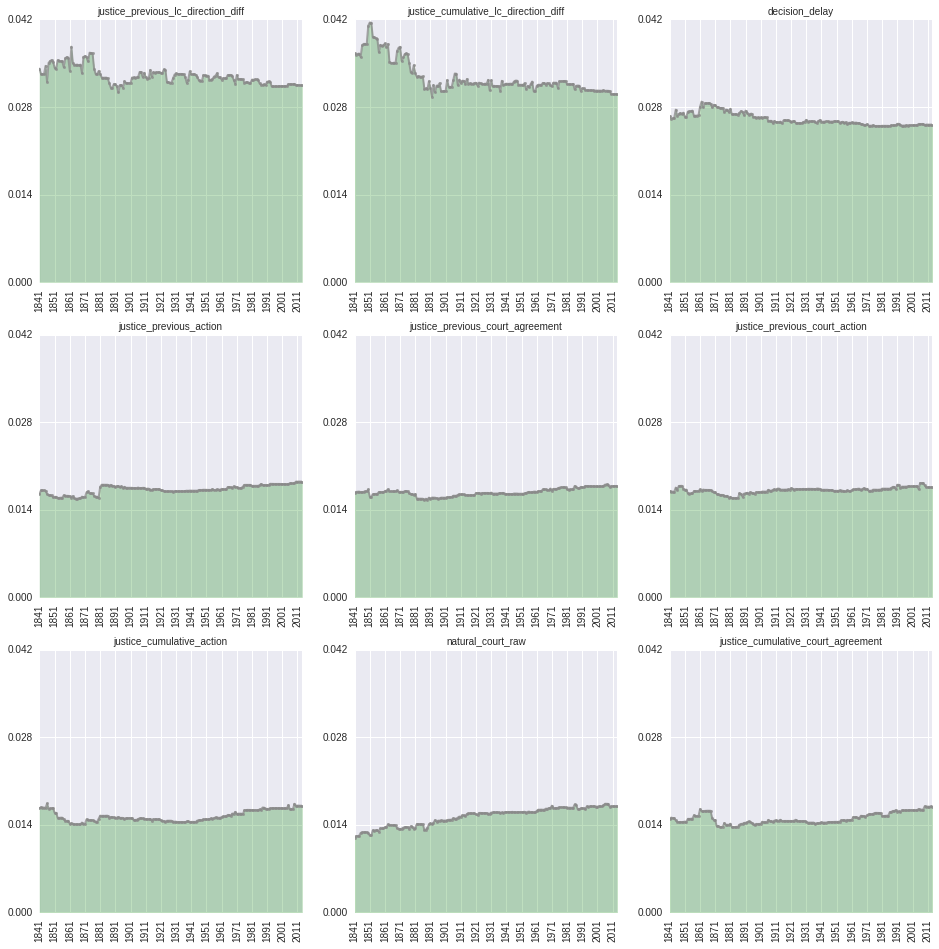

In [29]:
# Get last step weights
num_feature_rows = 3
num_feature_cols = 3
num_feature_total = num_feature_rows * num_feature_cols
last_step = feature_importance_ts.tail(1).T
last_step_top_features = last_step.sort_values(last_step.columns[0], ascending=False).head(num_feature_total).index.tolist()

# Get axis data
min_term = feature_importance_df["term"].min()
max_term = feature_importance_df["term"].max()
min_val = feature_importance_df["importance"].min()
max_val = feature_importance_df["importance"].max()

# Setup grid
#f = plt.figure(figsize=(16, 16))
f, ax = plt.subplots(num_feature_rows, num_feature_cols, figsize=(16,16))

for i in range(len(last_step_top_features)):
    # Get iteration indices
    row_id = int(i / num_feature_cols)
    col_id = (i % num_feature_cols)
    feature_name = last_step_top_features[i]
    
    # Setup title and data
    ax[row_id, col_id].set_title("{0}".format(feature_name), fontsize=10)
    ts_data = feature_importance_ts.loc[:, feature_name]
    
    # Plot fill and marker
    ax[row_id, col_id].fill_between(ts_data.index, 0, ts_data, alpha=0.25, color="green")
    ax[row_id, col_id].plot(ts_data.index, ts_data, marker="o", markersize=3, linewidth=2, color="#898989", alpha=0.75)
    
    # Setup axes
    ax[row_id, col_id].set_xlim(min_term, max_term)
    ax[row_id, col_id].set_xticks(numpy.arange(min_term, max_term, 10))
    ax[row_id, col_id].set_xticklabels(map(str, numpy.arange(min_term, max_term, 10)), rotation=90)
    ax[row_id, col_id].set_ylim(min_val, max_val)
    ax[row_id, col_id].set_yticks(numpy.round(numpy.linspace(min_val, max_val, 4), 3))

# Save as PNG, PDF, and SVG
plt.savefig("../figures/figure_feature_importance_ts_{0}.png".format(file_timestamp))
plt.savefig("../figures/figure_feature_importance_ts_{0}.pdf".format(file_timestamp))
plt.savefig("../figures/figure_feature_importance_ts_{0}.svg".format(file_timestamp))

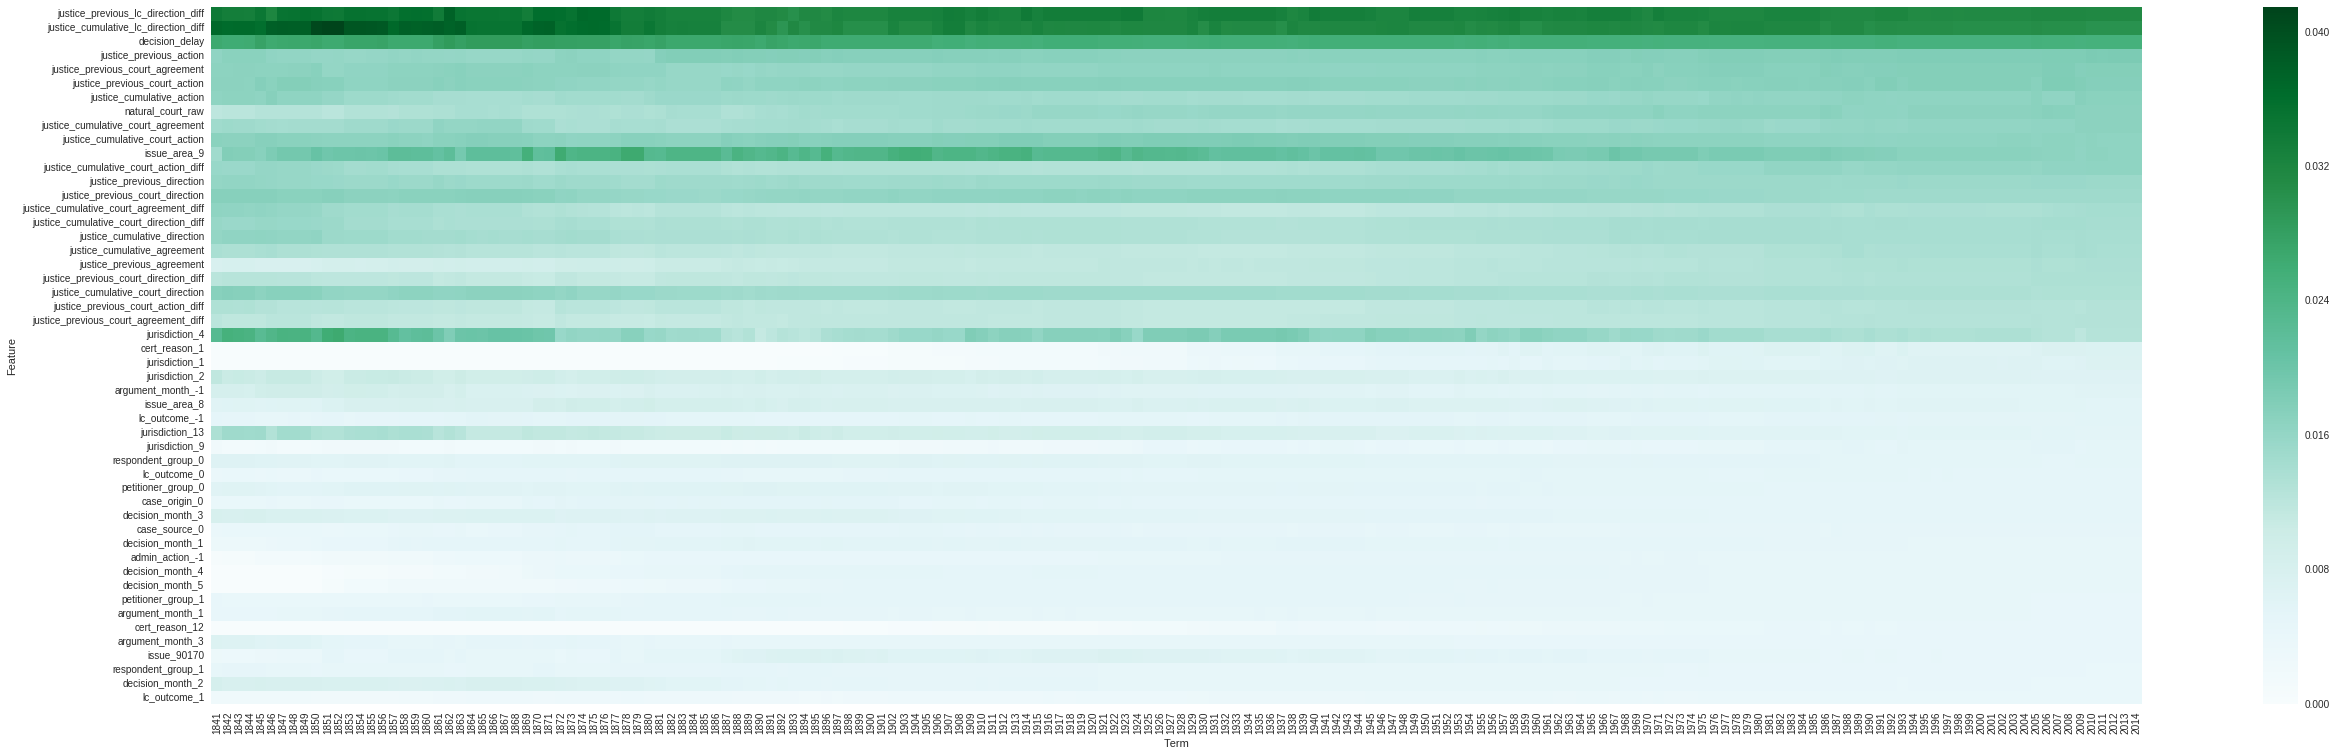

In [30]:
# Top features
num_feature_total = 50
last_step = feature_importance_ts.tail(1).T
last_step_top_features = last_step.sort_values(last_step.columns[0], ascending=False).head(num_feature_total).index.tolist()

# Get axis data
min_term = feature_importance_df["term"].min()
max_term = feature_importance_df["term"].max()
min_val = feature_importance_df["importance"].min()
max_val = feature_importance_df["importance"].max()

# Heatmap
f = plt.figure(figsize=((max_term - min_term) / 4, num_feature_total / 4))
seaborn.heatmap(feature_importance_ts.loc[:, last_step_top_features].T, vmin=min_val, vmax=max_val, cmap="BuGn")
plt.xlabel("Term")
plt.ylabel("Feature")

# Save as PNG, PDF, and SVG
plt.savefig("../figures/figure_feature_importance_heatmap_{0}.png".format(file_timestamp))
plt.savefig("../figures/figure_feature_importance_heatmap_{0}.pdf".format(file_timestamp))
plt.savefig("../figures/figure_feature_importance_heatmap_{0}.svg".format(file_timestamp))

## Justice Accuracy Heatmap

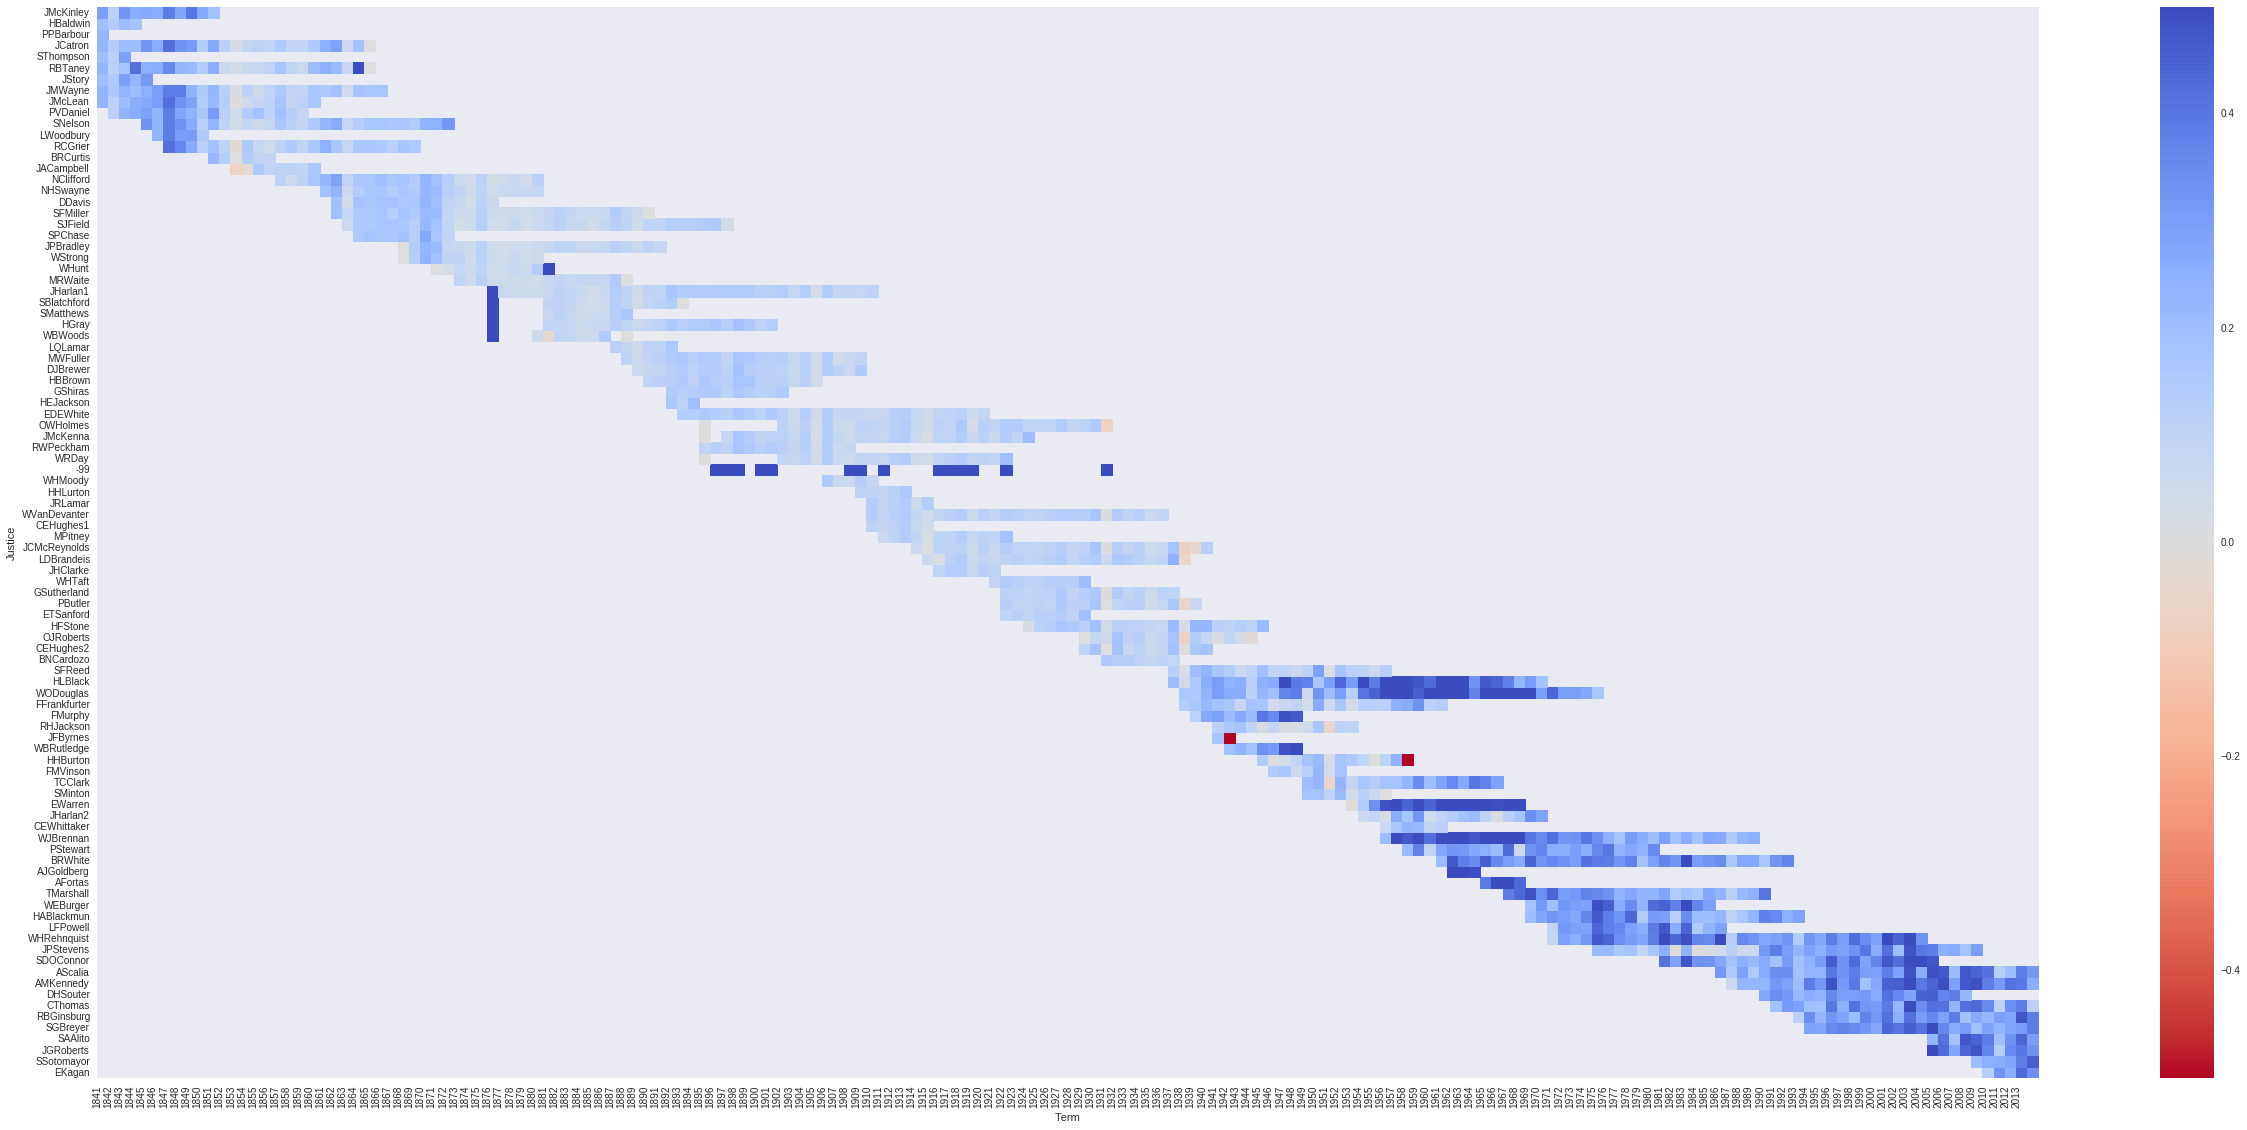

In [31]:
# Setup grouping over evaluation index
evaluation_index = raw_data.loc[:, "term"].isin(term_range) & -raw_data.loc[:, "case_outcome_disposition"].isnull()
justice_order = raw_data.loc[evaluation_index, :].groupby(["justiceName"])["term"].min().sort_values().index.tolist()
justice_accuracy_ts = raw_data.loc[evaluation_index, :].groupby(["term", "justiceName"])["rf_correct"].mean().unstack() - \
    raw_data.loc[evaluation_index, :].groupby(["term", "justiceName"])["dummy_correct"].mean().unstack()
min_term = min(justice_accuracy_ts.index)
max_term = max(justice_accuracy_ts.index)

# Setup plot
num_justices = justice_accuracy_ts.shape[1]
num_years = justice_accuracy_ts.shape[0]
f, ax = plt.subplots(figsize=(num_years / 4, num_justices / 5))
seaborn.heatmap(justice_accuracy_ts.loc[:, justice_order].T, cmap="coolwarm_r", vmin=-0.5, vmax=0.5, ax=ax)

# Setup labels
_ = ax.set_xticks(numpy.arange(0, max_term - min_term, 1))
_ = ax.set_xticklabels(map(str, numpy.arange(min_term, max_term, 1)), rotation=90)
ax.set_xlabel("Term")
ax.set_ylabel("Justice")

# Save as PNG, PDF, and SVG
plt.savefig("../figures/figure_justice_accuracy_heatmap_{0}.png".format(file_timestamp))
plt.savefig("../figures/figure_justice_accuracy_heatmap_{0}.pdf".format(file_timestamp))
plt.savefig("../figures/figure_justice_accuracy_heatmap_{0}.svg".format(file_timestamp))

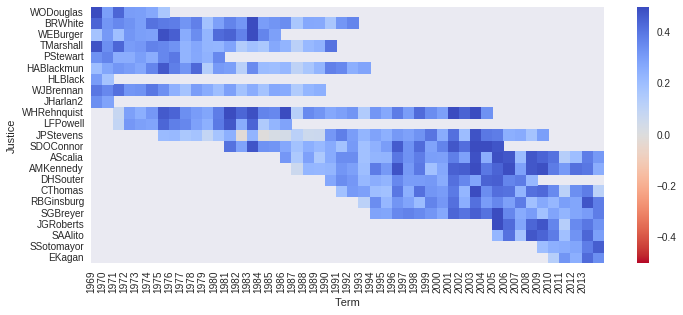

In [32]:
# Setup grouping over evaluation index
evaluation_index = (raw_data.loc[:, "naturalCourt"] >= 1500) & -raw_data.loc[:, "case_outcome_disposition"].isnull()
justice_order = raw_data.loc[evaluation_index, :].groupby(["justiceName"])["term"].min().sort_values().index.tolist()
justice_accuracy_ts = raw_data.loc[evaluation_index, :].groupby(["term", "justiceName"])["rf_correct"].mean().unstack() - \
    raw_data.loc[evaluation_index, :].groupby(["term", "justiceName"])["dummy_correct"].mean().unstack()
min_term = min(justice_accuracy_ts.index)
max_term = max(justice_accuracy_ts.index)
    
# Setup plot
num_justices = justice_accuracy_ts.shape[1]
num_years = justice_accuracy_ts.shape[0]
f, ax = plt.subplots(figsize=(num_years / 4, num_justices / 5))
seaborn.heatmap(justice_accuracy_ts.loc[:, justice_order].T, cmap="coolwarm_r", vmin=-0.5, vmax=0.5, ax=ax)

# Setup labels
_ = ax.set_xticks(numpy.arange(0, max_term - min_term, 1))
_ = ax.set_xticklabels(map(str, numpy.arange(min_term, max_term, 1)), rotation=90)
ax.set_xlabel("Term")
ax.set_ylabel("Justice")

# Save as PNG, PDF, and SVG
plt.savefig("../figures/figure_justice_accuracy_post_burger_heatmap_{0}.png".format(file_timestamp))
plt.savefig("../figures/figure_justice_accuracy_post_burger_heatmap_{0}.pdf".format(file_timestamp))
plt.savefig("../figures/figure_justice_accuracy_post_burger_heatmap_{0}.svg".format(file_timestamp))

## Performance by vote configurations

In [33]:
evaluation_index = raw_data.loc[:, "term"].isin(term_range) & -raw_data.loc[:, "case_outcome_disposition"].isnull()
case_config_data = []

for docket_id, docket_data in raw_data.loc[evaluation_index, :].groupby("docketId"):
    # Avoid very irregular cases
    if docket_data.shape[0] > 9:
        continue
    
    # Setup description
    vote_counts = docket_data.loc[:, "justice_outcome_disposition"].value_counts()
    reverse_count = vote_counts.ix[1] if 1 in vote_counts.index else 0
    affirm_count = docket_data.shape[0] - reverse_count
    if reverse_count > affirm_count:
        config_string = "{0}-{1} reverse".format(reverse_count, affirm_count)
    else:
        config_string = "{0}-{1} affirm".format(affirm_count, reverse_count)
        
    # Setup predicted
    vote_counts_predicted = docket_data.loc[:, "rf_predicted"].value_counts()
    reverse_count_predicted = vote_counts_predicted.ix[1] if 1 in vote_counts_predicted.index else 0
    affirm_count_predicted = docket_data.shape[0] - reverse_count_predicted
    if reverse_count_predicted > affirm_count_predicted:
        config_string_predicted = "{0}-{1} reverse".format(reverse_count_predicted, affirm_count_predicted)
        case_outcome_predicted = 1
    else:
        config_string_predicted = "{0}-{1} affirm".format(affirm_count_predicted, reverse_count_predicted)
        case_outcome_predicted = 0
        
    # Setup dummy
    vote_counts_dummy = docket_data.loc[:, "dummy_predicted"].value_counts()
    reverse_count_dummy = vote_counts_dummy.ix[1] if 1 in vote_counts_dummy.index else 0
    affirm_count_dummy = docket_data.shape[0] - reverse_count_dummy
    if reverse_count_dummy > affirm_count_dummy:
        config_string_dummy = "{0}-{1} reverse".format(reverse_count_dummy, affirm_count_dummy)
        case_outcome_dummy = 1
    else:
        config_string_dummy = "{0}-{1} affirm".format(affirm_count_dummy, reverse_count_dummy)
        case_outcome_dummy = 0
    
    # Print
    case_config_data.append((docket_id, docket_data.loc[:, "term"].values[0], config_string, 
                             int(docket_data.loc[:, "case_outcome_disposition"].values[0] > 0),
                            config_string_predicted, case_outcome_predicted,
                            config_string_dummy, case_outcome_dummy))

# Setup as DF
case_config_df = pandas.DataFrame(case_config_data, columns=["docket_id", "term", 
                                                             "actual_configuration", "actual_outcome", 
                                                             "predicted_configuration", "predicted_outcome",
                                                            "dummy_configuration", "dummy_outcome"])
case_config_df.loc[:, "rf_correct"] = (case_config_df["actual_outcome"] == case_config_df["predicted_outcome"]).astype(int)
case_config_df.loc[:, "dummy_correct"] = (case_config_df["actual_outcome"] == case_config_df["dummy_outcome"]).astype(int)
case_config_df.set_index(case_config_df["docket_id"], inplace=True)

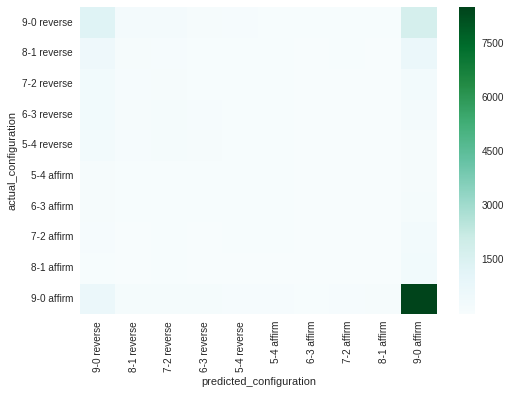

In [34]:
all_configuration_crosstab = pandas.crosstab(case_config_df["actual_configuration"], case_config_df["predicted_configuration"])
configuration_list = ['9-0 reverse',
                      '8-1 reverse',
                      '7-2 reverse',
                      '6-3 reverse',
                      '5-4 reverse',
                      '5-4 affirm',
                      '6-3 affirm',
                      '7-2 affirm',
                      '8-1 affirm',
                      '9-0 affirm'
                     ]
seaborn.heatmap(all_configuration_crosstab.loc[configuration_list, configuration_list], cmap="BuGn")

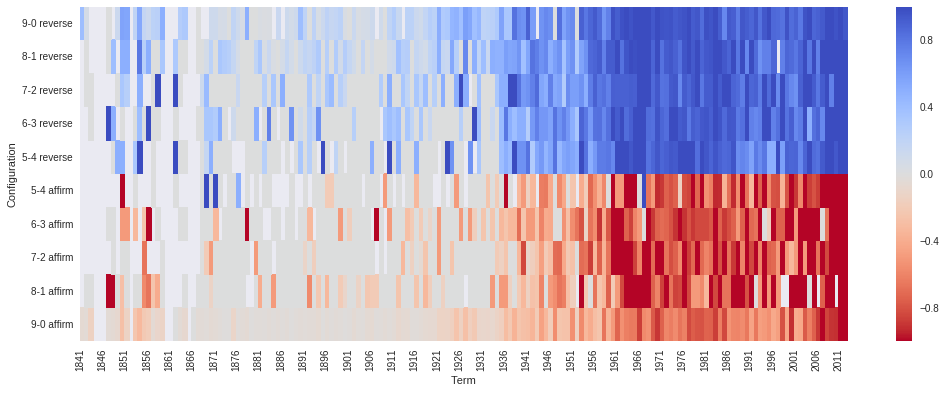

In [35]:
# Re-shape average correct
case_config_ts = case_config_df.groupby(["term", "actual_configuration"])["rf_correct"].mean().unstack() - \
    case_config_df.groupby(["term", "actual_configuration"])["dummy_correct"].mean().unstack()
min_term = min(case_config_ts.index)
max_term = max(case_config_ts.index)
    
# Setup plot
num_configs = case_config_ts.shape[1]
num_years = case_config_ts.shape[0]
f, ax = plt.subplots(figsize=(num_years / 10, num_configs / 5))
seaborn.heatmap(case_config_ts.loc[:, configuration_list].T, cmap="coolwarm_r")

# Setup labels
_ = ax.set_xticks(numpy.arange(0, max_term - min_term, 5))
_ = ax.set_xticklabels(map(str, numpy.arange(min_term, max_term, 5)), rotation=90)
ax.set_xlabel("Term")
ax.set_ylabel("Configuration")

# Save as PNG, PDF, and s
plt.savefig("../figures/figure_configuration_accuracy_heatmap_{0}.png".format(file_timestamp))
plt.savefig("../figures/figure_configuration_accuracy_heatmap_{0}.pdf".format(file_timestamp))
plt.savefig("../figures/figure_configuration_accuracy_heatmap_{0}.svg".format(file_timestamp))

## Overall Performance Comparison

In [39]:
# Combine series into one yearly TS
annual_ts = pandas.DataFrame([rf_correct_ts, dummy_correct_ts, rf_correct_case_ts, dummy_correct_case_ts]).T
annual_ts.loc[:, "term"] = annual_ts.index
annual_ts.head()
annual_ts_melt = pandas.melt(annual_ts, id_vars=["term"])

# Now plot stacked
#seaborn.barplot(x="term", y="value", hue="variable", data=annual_ts_melt)

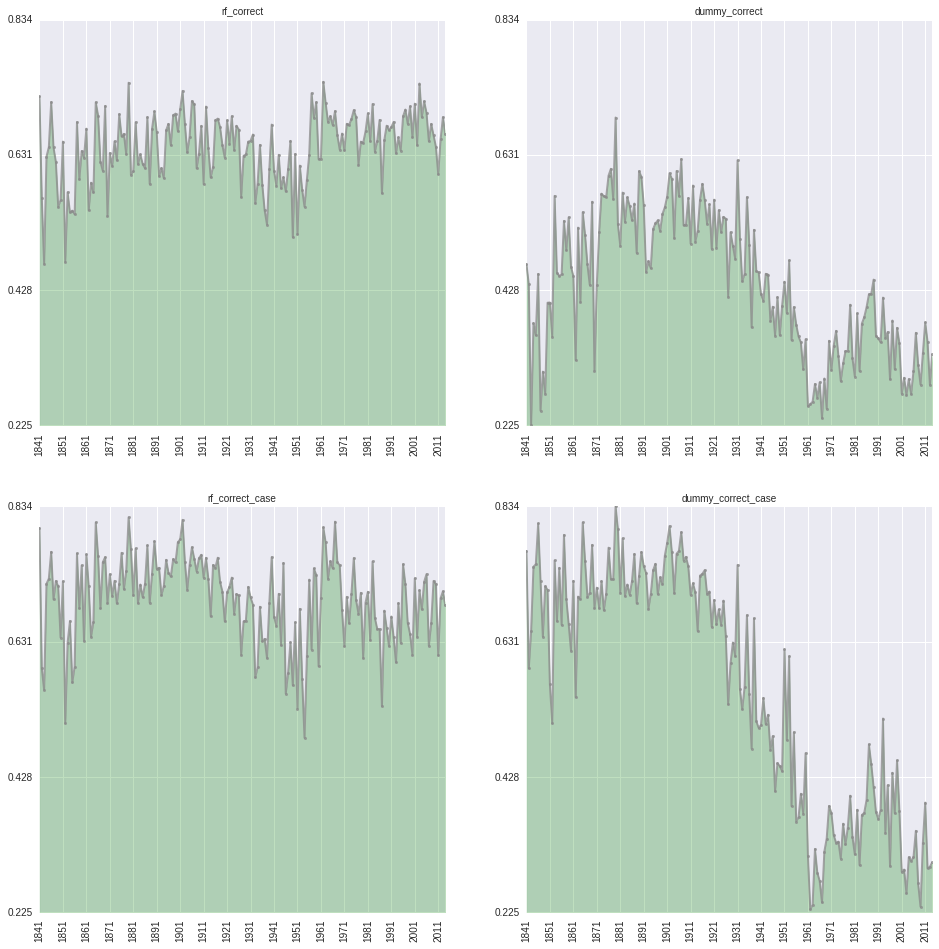

In [41]:
# Get last step weights
num_feature_rows = 2
num_feature_cols = 2
num_feature_total = num_feature_rows * num_feature_cols

# Get axis data
min_term = annual_ts_melt["term"].min()
max_term = annual_ts_melt["term"].max()
min_val = annual_ts_melt["value"].min()
max_val = annual_ts_melt["value"].max()

# Setup grid
#f = plt.figure(figsize=(16, 16))
f, ax = plt.subplots(num_feature_rows, num_feature_cols, figsize=(16,16))

for i in range(annual_ts.shape[1]-1):
    # Handle 
    row_id = int(i / num_feature_cols)
    col_id = (i % num_feature_cols)
    column_name = annual_ts.columns[i]
    ts_data = annual_ts.loc[:, annual_ts.columns[i]]

    # Setup title and data
    ax[row_id, col_id].set_title("{0}".format(column_name), fontsize=10)

    # Plot fill and marker
    ax[row_id, col_id].fill_between(ts_data.index, 0, ts_data, alpha=0.25, color="green")
    ax[row_id, col_id].plot(ts_data.index, ts_data, marker="o", markersize=3, linewidth=2, color="#898989", alpha=0.75)

    # Setup axes
    ax[row_id, col_id].set_xlim(min_term, max_term)
    ax[row_id, col_id].set_xticks(numpy.arange(min_term, max_term, 10))
    ax[row_id, col_id].set_xticklabels(map(str, numpy.arange(min_term, max_term, 10)), rotation=90)
    ax[row_id, col_id].set_ylim(min_val, max_val)
    ax[row_id, col_id].set_yticks(numpy.round(numpy.linspace(min_val, max_val, 4), 3))

# Save as PNG, PDF, and SVG
plt.savefig("../figures/figure_accuracy_ts_{0}.png".format(file_timestamp))
plt.savefig("../figures/figure_accuracy_ts_{0}.pdf".format(file_timestamp))
plt.savefig("../figures/figure_accuracy_ts_{0}.svg".format(file_timestamp))

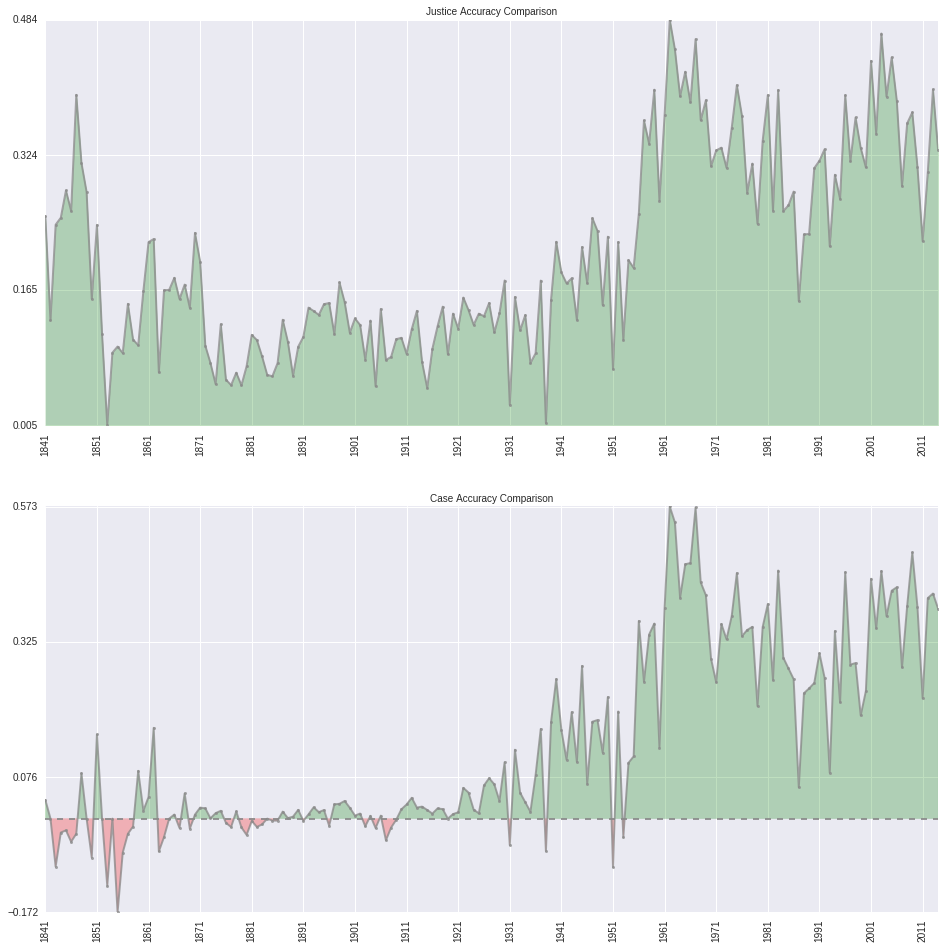

In [43]:
# Get last step weights
num_feature_rows = 2
num_feature_cols = 1
num_feature_total = num_feature_rows * num_feature_cols

# Get axis data
min_term = annual_ts_melt["term"].min()
max_term = annual_ts_melt["term"].max()

# Setup grid
#f = plt.figure(figsize=(16, 16))
f, ax = plt.subplots(num_feature_rows, num_feature_cols, figsize=(16,16))

# Handle justice accuracy
ax_id = 0
column_name = "Justice Accuracy Comparison"

# Setup title and data
ax[ax_id].set_title("{0}".format(column_name), fontsize=10)
ts_data = annual_ts.loc[:, "rf_correct"] - annual_ts.loc[:, "dummy_correct"]
min_val = ts_data.min()
max_val = ts_data.max()

# Plot fill and marker
ax[ax_id].axhline(0.0, linestyle='--', color='#898989') # horizontal lines
ax[ax_id].fill_between(ts_data.index, 0, ts_data, where=(ts_data >= 0), alpha=0.25, color="green", interpolate=True)
ax[ax_id].fill_between(ts_data.index, 0, ts_data, where=(ts_data < 0), alpha=0.25, color="red", interpolate=True)
ax[ax_id].plot(ts_data.index, ts_data, marker="o", markersize=3, linewidth=2, color="#898989", alpha=0.75)

# Setup axes
_ = ax[ax_id].set_xlim(min_term, max_term)
_ = ax[ax_id].set_xticks(numpy.arange(min_term, max_term, 10))
_ = ax[ax_id].set_xticklabels(map(str, numpy.arange(min_term, max_term, 10)), rotation=90)
_ = ax[ax_id].set_ylim(min_val, max_val)
_ = ax[ax_id].set_yticks(numpy.round(numpy.linspace(min_val, max_val, 4), 3))

# Handle justice accuracy
ax_id = 1
column_name = "Case Accuracy Comparison"

# Setup title and data
ax[ax_id].set_title("{0}".format(column_name), fontsize=10)
ts_data = annual_ts.loc[:, "rf_correct_case"] - annual_ts.loc[:, "dummy_correct_case"]
min_val = ts_data.min()
max_val = ts_data.max()

# Plot fill and marker
ax[ax_id].axhline(0.0, linestyle='--', color='#898989') # horizontal lines
ax[ax_id].fill_between(ts_data.index, 0, ts_data, where=(ts_data >= 0), alpha=0.25, color="green", interpolate=True)
ax[ax_id].fill_between(ts_data.index, 0, ts_data, where=(ts_data < 0), alpha=0.25, color="red", interpolate=True)
ax[ax_id].plot(ts_data.index, ts_data, marker="o", markersize=3, linewidth=2, color="#898989", alpha=0.75)

# Setup axes
_ = ax[ax_id].set_xlim(min_term, max_term)
_ = ax[ax_id].set_xticks(numpy.arange(min_term, max_term, 10))
_ = ax[ax_id].set_xticklabels(map(str, numpy.arange(min_term, max_term, 10)), rotation=90)
_ = ax[ax_id].set_ylim(min_val, max_val)
_ = ax[ax_id].set_yticks(numpy.round(numpy.linspace(min_val, max_val, 4), 3))

# Save as PNG, PDF, and SVG
plt.savefig("../figures/figure_accuracy_comparison_{0}.png".format(file_timestamp))
plt.savefig("../figures/figure_accuracy_comparison_{0}.pdf".format(file_timestamp))
plt.savefig("../figures/figure_accuracy_comparison_{0}.svg".format(file_timestamp))

## Tree Visualizations

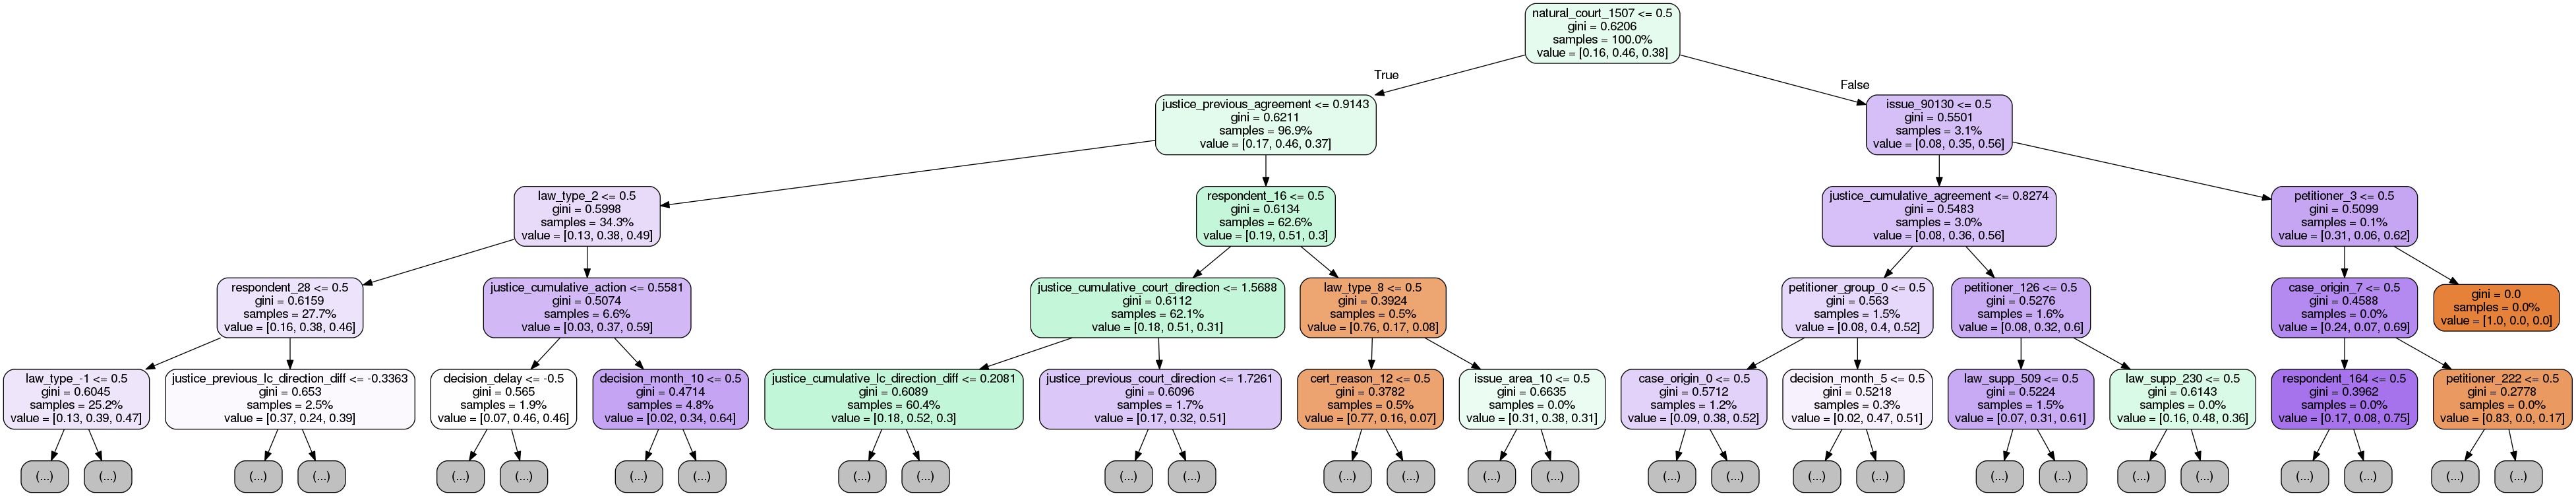

In [36]:
# Imports
import os
import pandas
from IPython.display import Image

# Visualize tree
sklearn.tree.export_graphviz(m.estimators_[0], max_depth=4, feature_names=feature_df.columns, filled=True, proportion=True, rounded=True)
os.system('dot -Tpng tree.dot -O')
Image(filename='tree.dot.png')

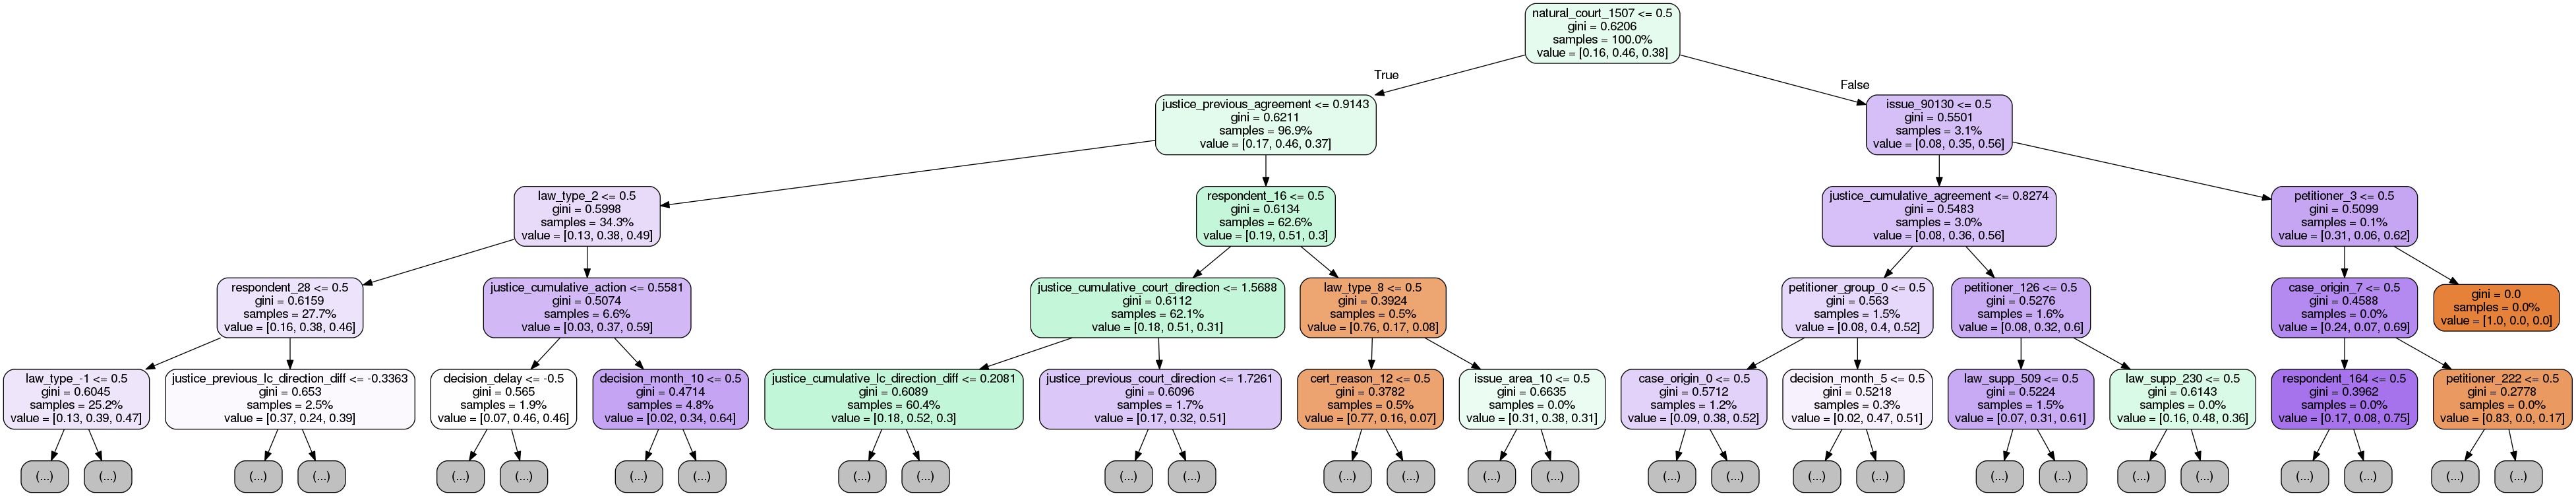

In [37]:
# Imports
import os
import pandas
from IPython.display import Image

# Visualize tree
sklearn.tree.export_graphviz(m.estimators_[1], max_depth=4, feature_names=feature_df.columns, filled=True, proportion=True, rounded=True)
os.system('dot -Tpng tree.dot -O')
Image(filename='tree.dot.png')

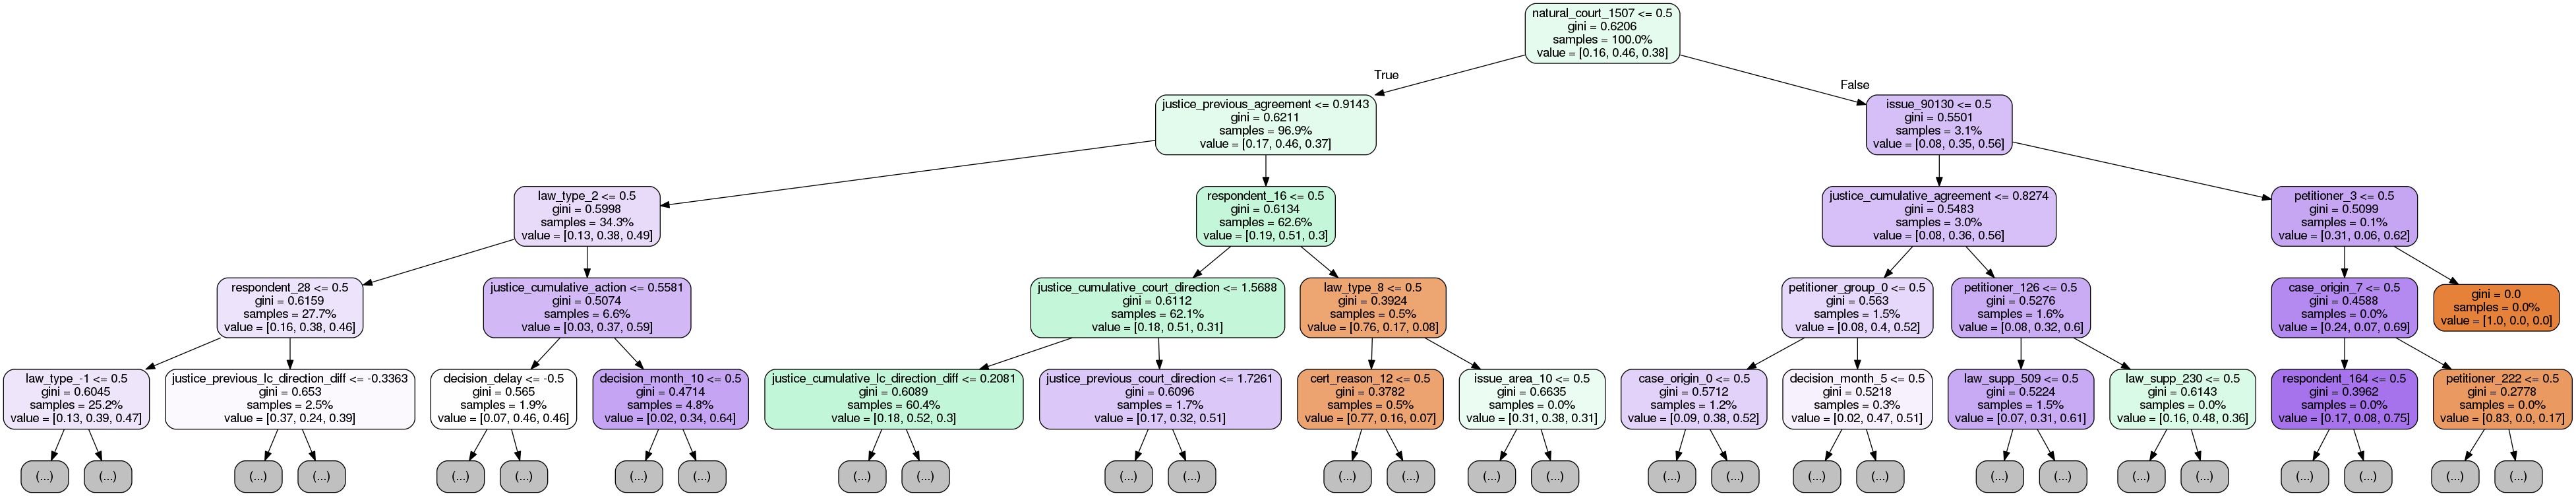

In [38]:
# Imports
import os
import pandas
from IPython.display import Image

# Visualize tree
sklearn.tree.export_graphviz(m.estimators_[2], max_depth=4, feature_names=feature_df.columns, filled=True, proportion=True, rounded=True)
os.system('dot -Tpng tree.dot -O')
Image(filename='tree.dot.png')